# Set up

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
import xrft
from torch.utils.data import DataLoader, TensorDataset
from utils import *
from train_gradu import *
from loss import *
from UNET import *

In [2]:
base_path = "gs://leap-persistent/YueWang/SSH/data"

def open_zarr(path):
    return xr.open_zarr(path, consolidated=True)

train = open_zarr(f"{base_path}/train_80.zarr").compute()
val = open_zarr(f"{base_path}/val_80.zarr").compute()
test = open_zarr(f"{base_path}/test_80.zarr").compute()
zca = open_zarr(f"{base_path}/zca_80.zarr").compute()

In [5]:
val

<xarray.Dataset> Size: 280MB
Dimensions:  (sample: 3645, i: 80, j: 80)
Coordinates:
  * sample   (sample) int64 29kB 0 1 2 3 4 5 6 ... 3639 3640 3641 3642 3643 3644
  * i        (i) int64 640B 0 1 2 3 4 5 6 7 8 9 ... 71 72 73 74 75 76 77 78 79
  * j        (j) int64 640B 0 1 2 3 4 5 6 7 8 9 ... 71 72 73 74 75 76 77 78 79
Data variables:
    ssh      (sample, i, j) float32 93MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ubm      (sample, i, j) float32 93MB nan nan nan nan nan ... nan nan nan nan
    bm       (sample, i, j) float32 93MB nan nan nan nan nan ... nan nan nan nan

In [4]:
zca

<xarray.Dataset> Size: 328MB
Dimensions:        (d: 6400, d2: 6400, d1: 6400)
Coordinates:
  * d2             (d2) int64 51kB 0 1 2 3 4 5 ... 6394 6395 6396 6397 6398 6399
  * d1             (d1) int64 51kB 0 1 2 3 4 5 ... 6394 6395 6396 6397 6398 6399
  * d              (d) int64 51kB 0 1 2 3 4 5 ... 6394 6395 6396 6397 6398 6399
Data variables:
    zca_scale_bm   (d) float64 51kB 0.02304 0.1538 ... 5.922e+03 7.883e+03
    zca_mean_bm    (d) float32 26kB -0.4188 -0.418 -0.4172 ... -0.4206 -0.4197
    zca_mean_ubm   (d) float32 26kB -0.0001894 -0.0001939 ... -0.0001786
    zca_Vt_bm      (d1, d2) float32 164MB -0.01142 -0.01141 ... -3.612e-05
    zca_Vt_ubm     (d1, d2) float32 164MB -0.002983 -0.003067 ... 0.0007045
    zca_scale_ubm  (d) float64 51kB 3.69 3.876 4.118 ... 1.2e+04 1.223e+04

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training data
x_train = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
y_train_channel_0 = torch.from_numpy(train.ubm.values).float().unsqueeze(1).to(device)
y_train_channel_1 = torch.from_numpy(train.zca_ubm.values).float().unsqueeze(1).to(device)

# Concatenate along channel dimension to create 2-channel output
y_train = torch.cat([y_train_channel_0, y_train_channel_1], dim=1)

# Prepare validation data (single channel)
x_val = torch.from_numpy(val.ssh.values).float().unsqueeze(1).to(device)
y_val = torch.from_numpy(val.ubm.values).float().unsqueeze(1).to(device)

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Vt = torch.from_numpy(zca.zca_Vt_ubm.values).float().to(device)
scale = torch.from_numpy(zca.zca_scale_ubm.values).float().to(device)
mean = torch.from_numpy(zca.zca_mean_ubm.values).float().to(device)


# Training

## loss

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GradLoss(nn.Module):
    def __init__(self):
        super(GradLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        
    def nan_mse_loss(self, output, target):
        mask = ~torch.isnan(target)
        if mask.sum() == 0:
            return torch.tensor(float('nan'), device=input.device)
        out = (output[mask] - target[mask]) ** 2
        return out.mean()
        
    def compute_gradient(self, img):
        sobel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32, device=img.device).unsqueeze(0).unsqueeze(0)
        sobel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32, device=img.device).unsqueeze(0).unsqueeze(0)
        
        grad_x = F.conv2d(img, sobel_x, padding=1, groups=img.shape[1])
        grad_y = F.conv2d(img, sobel_y, padding=1, groups=img.shape[1])
        
        return grad_x, grad_y

    def forward(self, output, target):

        # Gradient loss
        output_grad_x, output_grad_y = self.compute_gradient(output)
        target_grad_x, target_grad_y = self.compute_gradient(target)
        
        # Mask for gradient loss (propagate NaN mask to gradients)
        grad_mask = ~torch.isnan(target)
        grad_mask = grad_mask & F.pad(grad_mask[:, :, 1:, :], (0, 0, 1, 0))  # shift mask for x gradient
        grad_mask = grad_mask & F.pad(grad_mask[:, :, :, 1:], (1, 0, 0, 0))  # shift mask for y gradient
        
        grad_loss_x = self.nan_mse_loss(output_grad_x[grad_mask], target_grad_x[grad_mask])
        grad_loss_y = self.nan_mse_loss(output_grad_y[grad_mask], target_grad_y[grad_mask])
        grad_loss = grad_loss_x + grad_loss_y
   
        # Handle case where all losses are NaN
        if torch.isnan(grad_loss):
            return torch.tensor(0.0, device=output.device, requires_grad=True)
        
        return grad_loss



class MseLoss(nn.Module):
    def __init__(self):
        super(MseLoss, self).__init__()

    def forward(self, output, target):
        mask = ~torch.isnan(target)
        if mask.sum() == 0:
            return torch.tensor(float('nan'), device=output.device)
        out = (output[mask] - target[mask]) ** 2
        return out.mean()





class ZcaMseLoss(nn.Module):
    """
    Loss function that applies ZCA transformation to model outputs before 
    computing MSE against the target ground truth.
    
    This loss handles NaN values in the target.
    """
    
    def __init__(self):
        super(ZcaMseLoss, self).__init__()
    
    def forward(self, output, target, Vt, scale, mean):
        """
        Forward pass to compute the ZCA-MSE loss.
        
        Parameters:
        -----------
        output : torch.Tensor
            Model output tensor of shape (B, 1, H, W)
        target : torch.Tensor
            Target ground truth tensor of shape (B, 1, H, W)
        Vt : torch.Tensor
            The component matrix (eigenvectors transposed)
        scale : torch.Tensor
            The scale factors for the transformation
        mean : torch.Tensor
            The mean that was subtracted before ZCA
            
        Returns:
        --------
        loss : torch.Tensor
            The computed MSE loss between ZCA-transformed output and target.
        """
        # Apply ZCA whitening to model output
        output_zca = self.apply_zca_whitening_4d_torch(output, Vt, scale, mean)
        
        # Compute MSE between transformed output and target, handling NaNs
        mask = ~torch.isnan(target)
        if mask.sum() == 0:
            return torch.tensor(float('nan'), device=output.device)
        
        out = (output_zca[mask] - target[mask]) ** 2
        return out.mean()
    
    def apply_zca_whitening_4d_torch(self, data, Vt, scale, mean):
        """
        Apply ZCA whitening for 4D PyTorch tensors with shape (B, 1, H, W).
        
        Parameters:
        -----------
        data : torch.Tensor
            Input tensor of shape (B, 1, H, W)
        Vt : torch.Tensor
            The component matrix (eigenvectors transposed)
        scale : torch.Tensor
            The scale factors for the transformation
        mean : torch.Tensor
            The mean that was subtracted before ZCA
            
        Returns:
        --------
        whitened : torch.Tensor
            ZCA-whitened tensor of shape (B, 1, H, W)
        """
        original_shape = data.shape
        B = data.shape[0]
        # Flatten the data: shape (B, features)
        data_flat = data.reshape(B, -1)
        
        # Center data (no need to handle NaNs in output)
        data_centered = data_flat - mean
        
        # Apply transformation in 3 steps
        transformed = data_centered @ Vt.T    # (1) Project to PCA space
        transformed = transformed * scale      # (2) Scale components
        whitened = transformed @ Vt            # (3) Project back to original space
        
        return whitened.reshape(original_shape)



class GaussianLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(GaussianLoss, self).__init__()
        self.eps = eps
        
    def nan_gaussian_nll(self, mu, log_sigma, target):
        mask = ~torch.isnan(target)
        if mask.sum() == 0:
            return torch.tensor(float('nan'), device=mu.device)
            
        # Clamp sigma and compute corrected log_sigma
        sigma = torch.exp(log_sigma).clamp(min=self.eps)
        log_sigma_clamped = torch.log(sigma)  # Key correction
        
        # Use log_sigma_clamped instead of original log_sigma
        nll = log_sigma_clamped[mask] + 0.5 * ((target[mask] - mu[mask])**2) / (sigma[mask]**2)
        
        return nll.mean()
    
    def forward(self, outputs, target):
        mu = outputs[:, 0, ...]
        log_sigma = outputs[:, 1, ...]
        target_squeezed = target.squeeze(1)
        
        loss = self.nan_gaussian_nll(mu, log_sigma, target_squeezed)
        
        if torch.isnan(loss):
            return torch.tensor(0.0, device=outputs.device, requires_grad=True)
        return loss


## train

In [5]:
def train_model(model, train_loader, val_loader,
                Vt, scale, mean,
                optimizer, device,
                grad_loss_weight=1.0,  # Weight for GradLoss's gradient component
                zca_weight=1.0,        # Weight for ZCA loss
                save_path='/home/jovyan/SSH/B_data/updated_dm/test3/model.pth',
                n_epochs=2000,
                patience=50):

    """
    This function trains a deep learning model with probabilistic Gaussian loss, GradLoss and ZCA loss.
    
    Parameters:
    - model: The neural network model to be trained (outputs mu and log_sigma)
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - Vt, scale, mean: Pre-computed ZCA parameters
    - optimizer: Optimization algorithm
    - device: Device to run the model on (CPU or GPU)
    - grad_loss_weight: Weight for gradient component in GradLoss (default: 1.0)
    - zca_weight: Weight for ZCA loss component (default: 1.0)
    - probabilistic: Whether the model outputs probabilistic predictions (default: True)
    - save_path: Path to save the trained model
    - n_epochs: Number of training epochs
    - patience: Number of epochs to wait for improvement
    """

    model.to(device)
    
    # Use the pre-defined loss classes
    grad_loss_fn = GradLoss()
    zca_loss_fn = ZcaMseLoss()
    gaussian_loss_fn = GaussianLoss()  
    mse_loss_fn = MseLoss()  
    
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    # Variables for early stopping and loss tracking
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    # Check if a saved model exists and load it if it does
    if os.path.isfile(save_path):
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['best_val_loss']
        patience_counter = checkpoint['patience_counter']
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        print(f"Resuming from epoch {start_epoch} with best_val_loss = {best_val_loss:.3e}")
    else:
        start_epoch = 0

    # Main training loop
    for epoch in range(start_epoch, n_epochs):
        
        start_time = time.time()
        model.train()  # Set model to training mode
        train_running_loss = 0.0
        train_gaussian_losses = 0.0
        train_grad_losses = 0.0
        train_zca_losses = 0.0

        # Training phase
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            
            # Unpack the target data - channel 0 is physical space, channel 1 is ZCA space
            batch_y_physical = batch_y[:, 0:1, ...].to(device)  # Physical space target
            batch_y_zca = batch_y[:, 1:2, ...].to(device)      # ZCA space target
            
            # Forward pass
            outputs = model(batch_x)  # outputs has 2 channels: mu and log_sigma
            
            # Extract mu for gradient and ZCA losses
            mu = outputs[:, 0:1, ...]  # Keep dimension for grad and ZCA loss
            
            # Calculate Gaussian NLL Loss
            gaussian_loss = gaussian_loss_fn(outputs, batch_y_physical)
            
            # Calculate Grad Loss (using mu)
            grad_loss = grad_loss_fn(mu, batch_y_physical)
            
            # Calculate ZCA loss (using mu)
            zca_loss = zca_loss_fn(mu, batch_y_zca, Vt, scale, mean)
            
            # Combine losses
            loss = gaussian_loss + grad_loss_weight * grad_loss + zca_weight * zca_loss
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track losses
            train_running_loss += loss.item() * batch_x.size(0)
            train_gaussian_losses += gaussian_loss.item() * batch_x.size(0)
            train_grad_losses += grad_loss.item() * batch_x.size(0)
            train_zca_losses += zca_loss.item() * batch_x.size(0)
            
        # Calculate average training losses for the epoch
        epoch_loss = train_running_loss / len(train_loader.dataset)
        epoch_gaussian_loss = train_gaussian_losses / len(train_loader.dataset)
        epoch_grad_loss = train_grad_losses / len(train_loader.dataset)
        epoch_zca_loss = train_zca_losses / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(device)
                batch_y_physical = batch_y[:, 0:1, ...].to(device)  # Physical space target for validation
                
                # Forward pass
                outputs = model(batch_x)
                
                # For validation, we use MSE loss on the mean prediction (mu)
                mu = outputs[:, 0:1, ...]  # Extract mu and keep dimension
                loss = mse_loss_fn(mu, batch_y_physical)
                val_running_loss += loss.item() * batch_x.size(0)
                
        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)

        # Calculate epoch duration
        end_time = time.time()
        epoch_duration = end_time - start_time

        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.2e} (Gaussian: {epoch_gaussian_loss:.2e}, Grad: {epoch_grad_loss:.2e}, ZCA: {epoch_zca_loss:.2e}), "
              f"Val Loss: {val_loss:.2e}, Epoch Time: {epoch_duration:.2f}s")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save checkpoint only if we have a new best validation loss
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_loss': best_val_loss,
                'patience_counter': patience_counter,
                'train_losses': train_losses,
                'val_losses': val_losses
            }
            torch.save(checkpoint, save_path)
            print(f"Best model so far saved at epoch {epoch+1} (Val Loss: {best_val_loss:.3e})")
        else:
            patience_counter += 1
            print(f"Patience counter: {patience_counter}/{patience}")
        
        # Early stopping check
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
    
    print("Training complete")

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

# Create model and optimizer
model = UNet(in_channels=1, out_channels=2, initial_features=32, depth=4)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the modelJBVJ
train_model(model, train_loader, val_loader,
            Vt, scale, mean,  
            optimizer, device,
            grad_loss_weight=0.0,  # Weight for gradient loss
            zca_weight=10.0,        # Weight for ZCA loss
            save_path='/home/jovyan/GRL/checkpoint/gau_zca_10.pth',
            n_epochs=2000,
            patience=50)

/srv/conda/envs/notebook/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: 1.77e+04 (Gaussian: -7.93e-01, Grad: 7.61e-02, ZCA: 1.77e+03), Val Loss: 1.01e-01, Epoch Time: 125.35s
Best model so far saved at epoch 1 (Val Loss: 1.007e-01)


# Testing

In [7]:
x_test.shape

torch.Size([2000, 1, 108, 108])

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32

x_test = torch.from_numpy(test.ssh.values).float().unsqueeze(1).to(device)
y_test = torch.from_numpy(test.ubm.values).float().unsqueeze(1).to(device)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def evaluate_model(model, device, test_loader, ssh_test, checkpoint_path, probabilistic=False):
    """
    Evaluate model with flexibility for probabilistic or deterministic predictions,
    without ZCA transformation.
    
    Args:
        model: Neural network model
        device: Computing device (CPU/GPU)
        test_loader: DataLoader for test data
        ssh_test: Sea surface height test data
        checkpoint_path: Path to model checkpoint
        probabilistic: Boolean flag for probabilistic prediction (default: False)
    
    Returns:
        If probabilistic:
            ubm_mu_pred: Mean predictions in physical space
            ubm_sigma_pred: Standard deviation predictions in physical space
            bm_mu_pred: Balanced motion predictions
        If deterministic:
            ubm_pred: UBM predictions
            None: No uncertainty
            bm_pred: Balanced motion predictions
    """
    model = model.to(device)
    model.eval()
    eps = 1e-6

    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model parameters from {checkpoint_path}")
    else:
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

    predictions = []
    uncertainties = [] if probabilistic else None

    with torch.no_grad():
        for batch_x, _ in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            
            if probabilistic:
                # Split into mean and uncertainty
                mu = outputs[:, 0, ...].unsqueeze(1)
                log_sigma = outputs[:, 1, ...].unsqueeze(1)
                sigma = torch.exp(log_sigma).clamp(min=eps)
                
                predictions.append(mu.cpu())
                uncertainties.append(sigma.cpu())
            else:
                # For deterministic case, output is already the prediction
                predictions.append(outputs.cpu())

    # Process predictions
    if probabilistic:
        ubm_mu_pred = torch.cat(predictions, dim=0).numpy()
        ubm_sigma_pred = torch.cat(uncertainties, dim=0).numpy()
        
        # Convert to xarray if needed
        ubm_mu_prediction = xr_da(ubm_mu_pred.squeeze(1), ssh_test)
        bm_prediction = ssh_test - ubm_mu_prediction
        
        return ubm_mu_prediction, ubm_sigma_pred, bm_prediction
    else:
        # For deterministic case
        predictions_np = torch.cat(predictions, dim=0).numpy()
        
        # Convert to xarray if needed
        ubm_prediction = xr_da(predictions_np.squeeze(1), ssh_test)
        bm_prediction = ssh_test - ubm_prediction
        
        return ubm_prediction, None, bm_prediction


# For deterministic model
ubm_pred, _, bm_pred = evaluate_model(
    UNet(in_channels=1, out_channels=1, initial_features=16, depth=2), 
    device, 
    test_loader,
    test.ssh,
    '/home/jovyan/GRL/checkpoint/test1.pth',
    probabilistic=False
)

/tmp/ipykernel_876/2838441065.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded model parameters from /home/jovyan/GRL/checkpoint/test1.pth


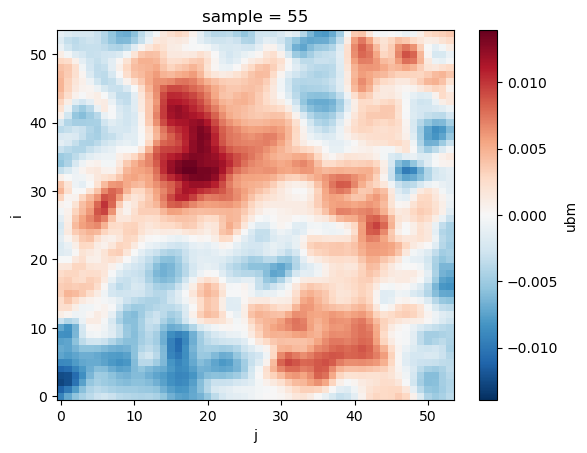

In [21]:
test.ubm.isel(sample=55).plot()

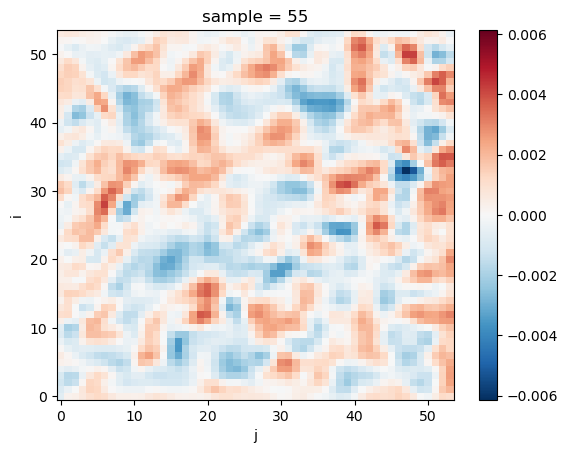

In [19]:
ubm_pred.isel(sample=55).plot()

/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)


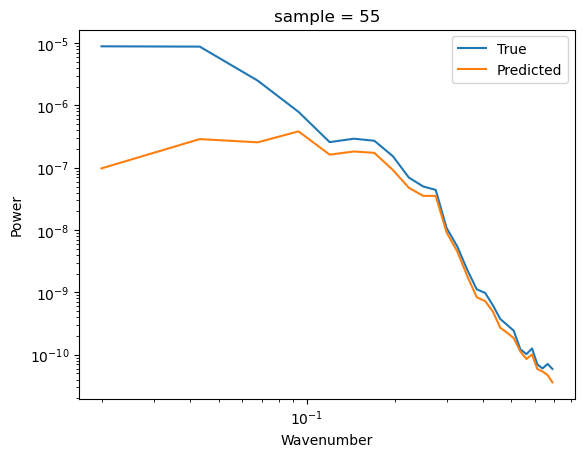

In [22]:
fig, ax = plt.subplots()

# Plot the first spectrum
isotropic_spectra(test.ubm.isel(sample=55).compute()).plot(ax=ax, xscale='log', yscale='log', label='True')

# Plot the second spectrum on the same axes
isotropic_spectra(ubm_pred.isel(sample=55).compute()).plot(ax=ax, xscale='log', yscale='log', label='Predicted')

# Set labels and legend
ax.set_xlabel('Wavenumber')
ax.set_ylabel('Power')
ax.legend()

plt.show()

In [51]:
def find_smallest_relative_error_indices(true_array, pred_array):
   # Calculate mean squared error per sample
   mse_per_sample = ((true_array - pred_array) ** 2).mean(axis=(1,2))
   
   # Calculate mean squared magnitude of true values per sample
   magnitude_per_sample = (true_array ** 2).mean(axis=(1,2))
   
   # Calculate relative error (MSE divided by magnitude)
   # Add small epsilon to avoid division by zero
   epsilon = 1e-10
   relative_error = mse_per_sample / (magnitude_per_sample + epsilon)
   

   best_indices = np.argsort(relative_error)[:30]
    
   worst_indices = np.argsort(relative_error)[-30:]
   
   return best_indices, worst_indices
    
best_indices, worst_indices = find_smallest_relative_error_indices(ubm_true_clean, ubm_zca_clean)

In [56]:
best_indices

<xarray.DataArray (sample: 30)> Size: 240B
array([1302, 1243, 1244,  209,  945, 1022,  631,   28,  210,  331,  944,
        644, 1295, 1321,  385, 1283, 1004,  932, 1301, 1320,  695,  102,
       1303,  509,  962, 1282,  996, 1003,  968, 1002])
Coordinates:
  * sample   (sample) int64 240B 21 22 23 24 25 26 27 ... 48 49 50 53 54 55 56

In [52]:
worst_indices

<xarray.DataArray (sample: 30)> Size: 240B
array([ 782, 1388,  495, 1375,  195,   60,  788, 1382, 1349,  459, 1143,
       1075, 1394, 1095,  229,  771, 1093,  775,  757, 1457,  795, 1094,
        759, 1112,  130, 1351, 1087, 1412, 1057, 1387])
Coordinates:
  * sample   (sample) int64 240B 1933 1934 1941 1942 ... 1971 1972 1973 1974

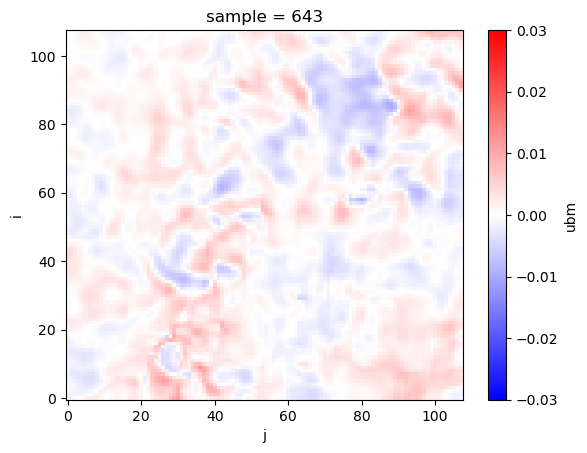

In [57]:
ubm_true_clean.isel(sample=495).plot(cmap='bwr', vmin=-0.03, vmax=0.03)

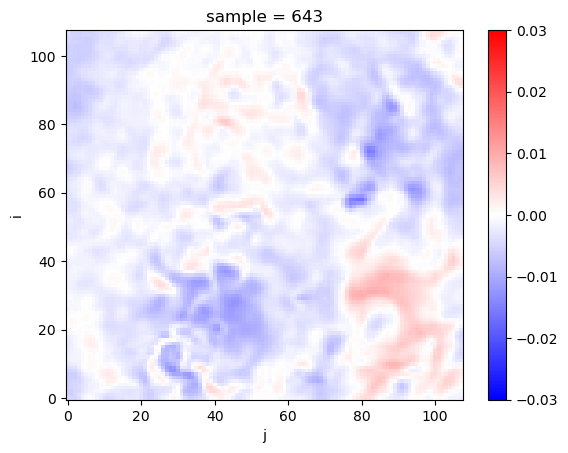

In [58]:
ubm_zca_clean.isel(sample=495).plot(cmap='bwr', vmin=-0.03, vmax=0.03)

/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)


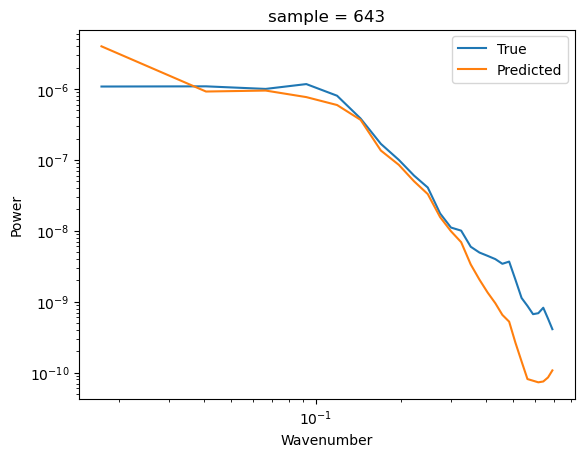

In [53]:
fig, ax = plt.subplots()

# Plot the first spectrum
isotropic_spectra(ubm_true_clean.isel(sample=495).compute()).plot(ax=ax, xscale='log', yscale='log', label='True')

# Plot the second spectrum on the same axes
isotropic_spectra(ubm_zca_clean.isel(sample=495).compute()).plot(ax=ax, xscale='log', yscale='log', label='Predicted')

# Set labels and legend
ax.set_xlabel('Wavenumber')
ax.set_ylabel('Power')
ax.legend()

plt.show()